### Please read below before running the notebook:

1. Please run this in google colab with GPU enabled. The BERT model takes Approximately 3 hours per epoch without GPU and with GPU enabled it takes Approximately 38min per epoch. <br>
    1.1 Install transformers if not installed already. The code for the installation has been commented. 

2. The content of the dataset is toxic so please go through it with caution. 

3. Evaluation metrics for Ridge regression is not shown as it was done for the purpose of competition and was evaluated directly on kaggle competition. 

4. The leading score in the competition as of writing this code was 0.886 and we achieved a score of 0.859 and stand in top 12%. 

5. The final score that we submitted for the competition was 0.83*(Probability output of BERT) + 0.17*(Output of Ridge model). The calculation step was done on the competition submission notebook and is not shown here. 

#### Note for Running: 

The notebook can be run as follows:

1. On colab: Runtime -> Runall
2. On the jupyter notebook: Kernel -> Restart and Run all.
3. Each cell can be individually run but the sequence in which it was run matters. 


In [4]:
# !pip install transformers[sentencepiece]

In [5]:
## Importing the necessary libraries
import re
import pandas as pd
import numpy as np
import string
import random
from wordcloud import STOPWORDS, WordCloud, ImageColorGenerator
from collections import defaultdict

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from PIL import Image

from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
df = pd.read_csv('training_data.csv')

In [12]:
df.head()

,less_toxic,more_toxic,score
0,I really couldn't give a fuck if i'm blocked x...,"""\n\nYOUR MOM IS SO FAT, SHE GETS CASHBACK WHE...",0.6
1,The Glue Theory \n\nI hate you and your ugly d...,"""\n\n FUCK YOU \nFUCK YOU!!! YOU'RE A STUPID ...",0.6
2,"""\n\nSorry, no? """"No"""" is what a master says ...",why don't you suck my ass until your lips blee...,0.6
3,Fk Off==\nFk off you Dragon Ball nerd. You lik...,honestly ==\nyou need to crawl under a rock an...,0.5
4,Can I Just Be Terminated. This Is Bullshit.,I am going to kill you \n\ni am going to get ...,0.5


#### Generating N grams

In [13]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [20]:
N = 20

## For plotting the graphs
def plot(less_toxic, more_toxic):
    fig, axes = plt.subplots(ncols=2, figsize=(18, N//2), dpi=100)
    plt.tight_layout()

    sns.barplot(y=less_toxic[0], x=less_toxic[1], ax=axes[0], color='green')
    sns.barplot(y=more_toxic[0], x=more_toxic[1], ax=axes[1], color='red')

    for i in range(2):
        axes[i].spines['right'].set_visible(False)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', labelsize=13)
        axes[i].tick_params(axis='y', labelsize=13)

    axes[0].set_title(f'Top {N} most common unigrams in less_toxic comments', fontsize=15)
    axes[1].set_title(f'Top {N} most common unigrams in more_toxic comments', fontsize=15)

    plt.show()

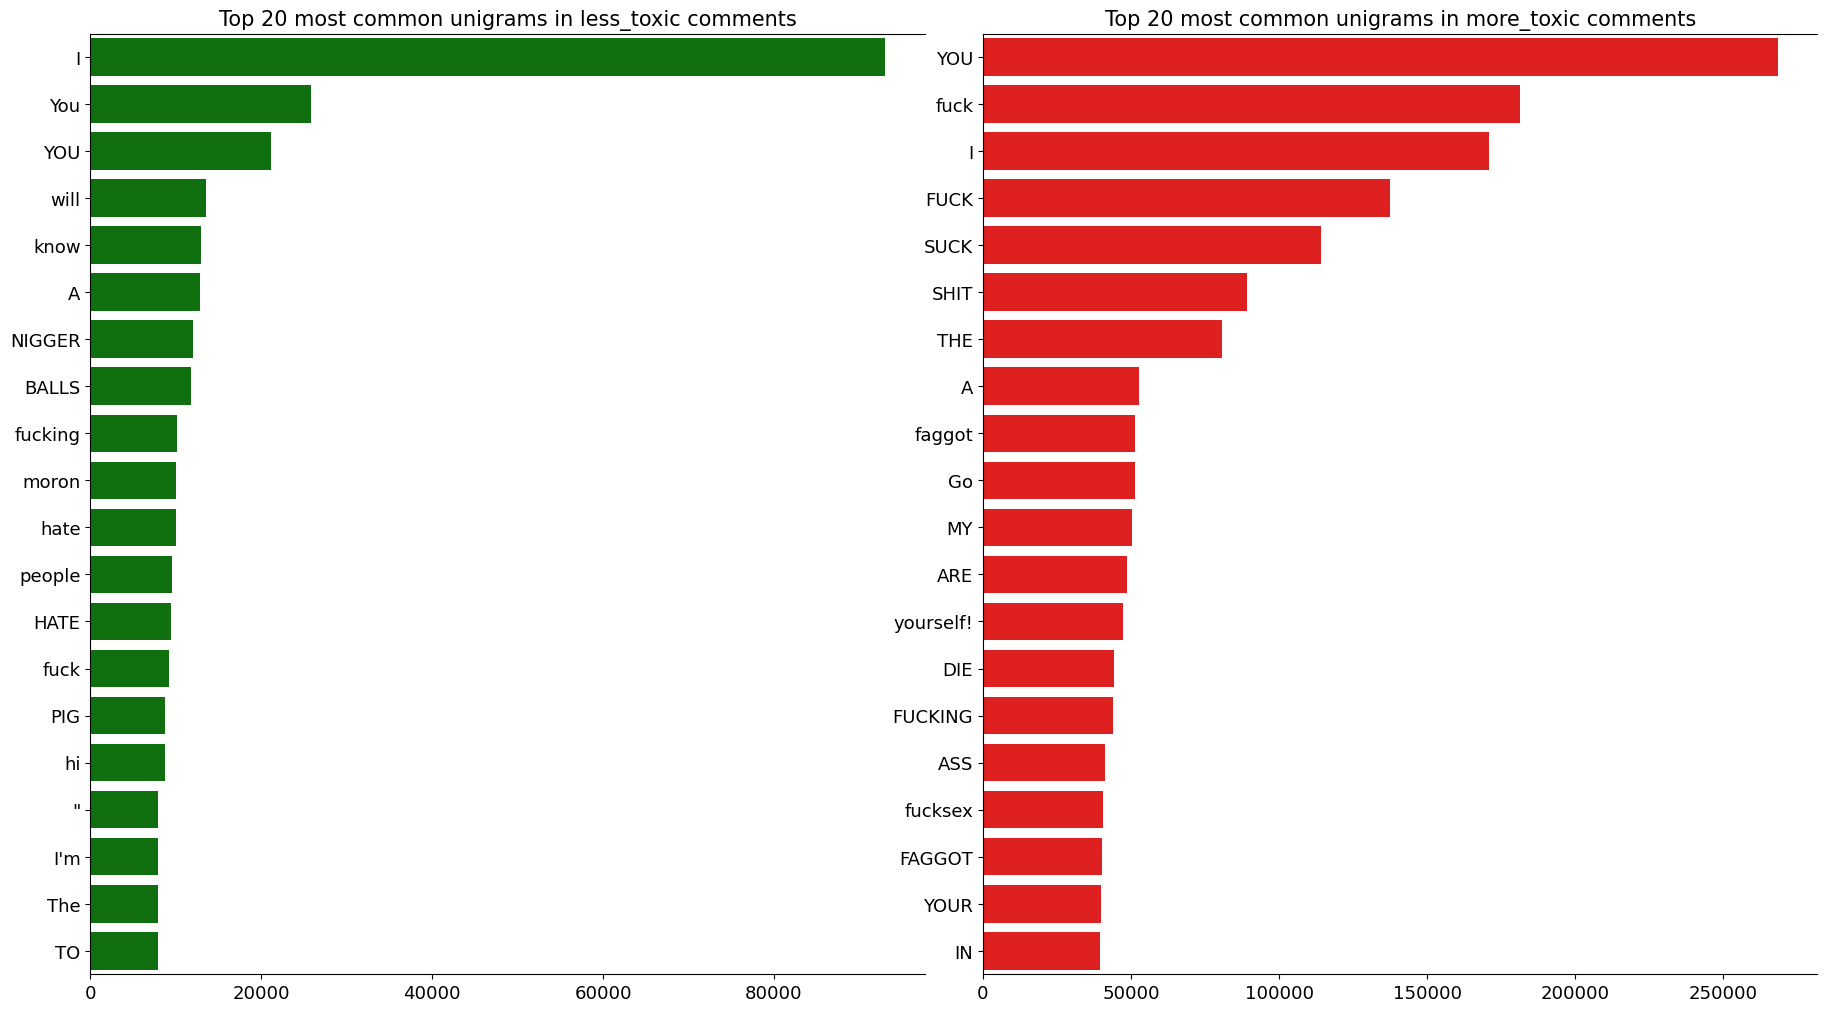

In [21]:
## Visualizing N-grams
less_toxic_unigrams = defaultdict(int)
for tweet in df['less_toxic']:
    for word in generate_ngrams(tweet, 1):
        less_toxic_unigrams[word] += 1
        
df_less_toxic_unigrams = pd.DataFrame(sorted(less_toxic_unigrams.items(), key=lambda x: x[1])[::-1])

unigrams_less_100 = df_less_toxic_unigrams[:N]

more_toxic_unigrams = defaultdict(int)
for tweet in df['more_toxic']:
    for word in generate_ngrams(tweet, 1):
        more_toxic_unigrams[word] += 1
        
df_more_toxic_unigrams = pd.DataFrame(sorted(more_toxic_unigrams.items(), key=lambda x: x[1])[::-1])

unigrams_more_100 = df_more_toxic_unigrams[:N]

plot(unigrams_less_100, unigrams_more_100)

In [ ]:
## Bi-grams

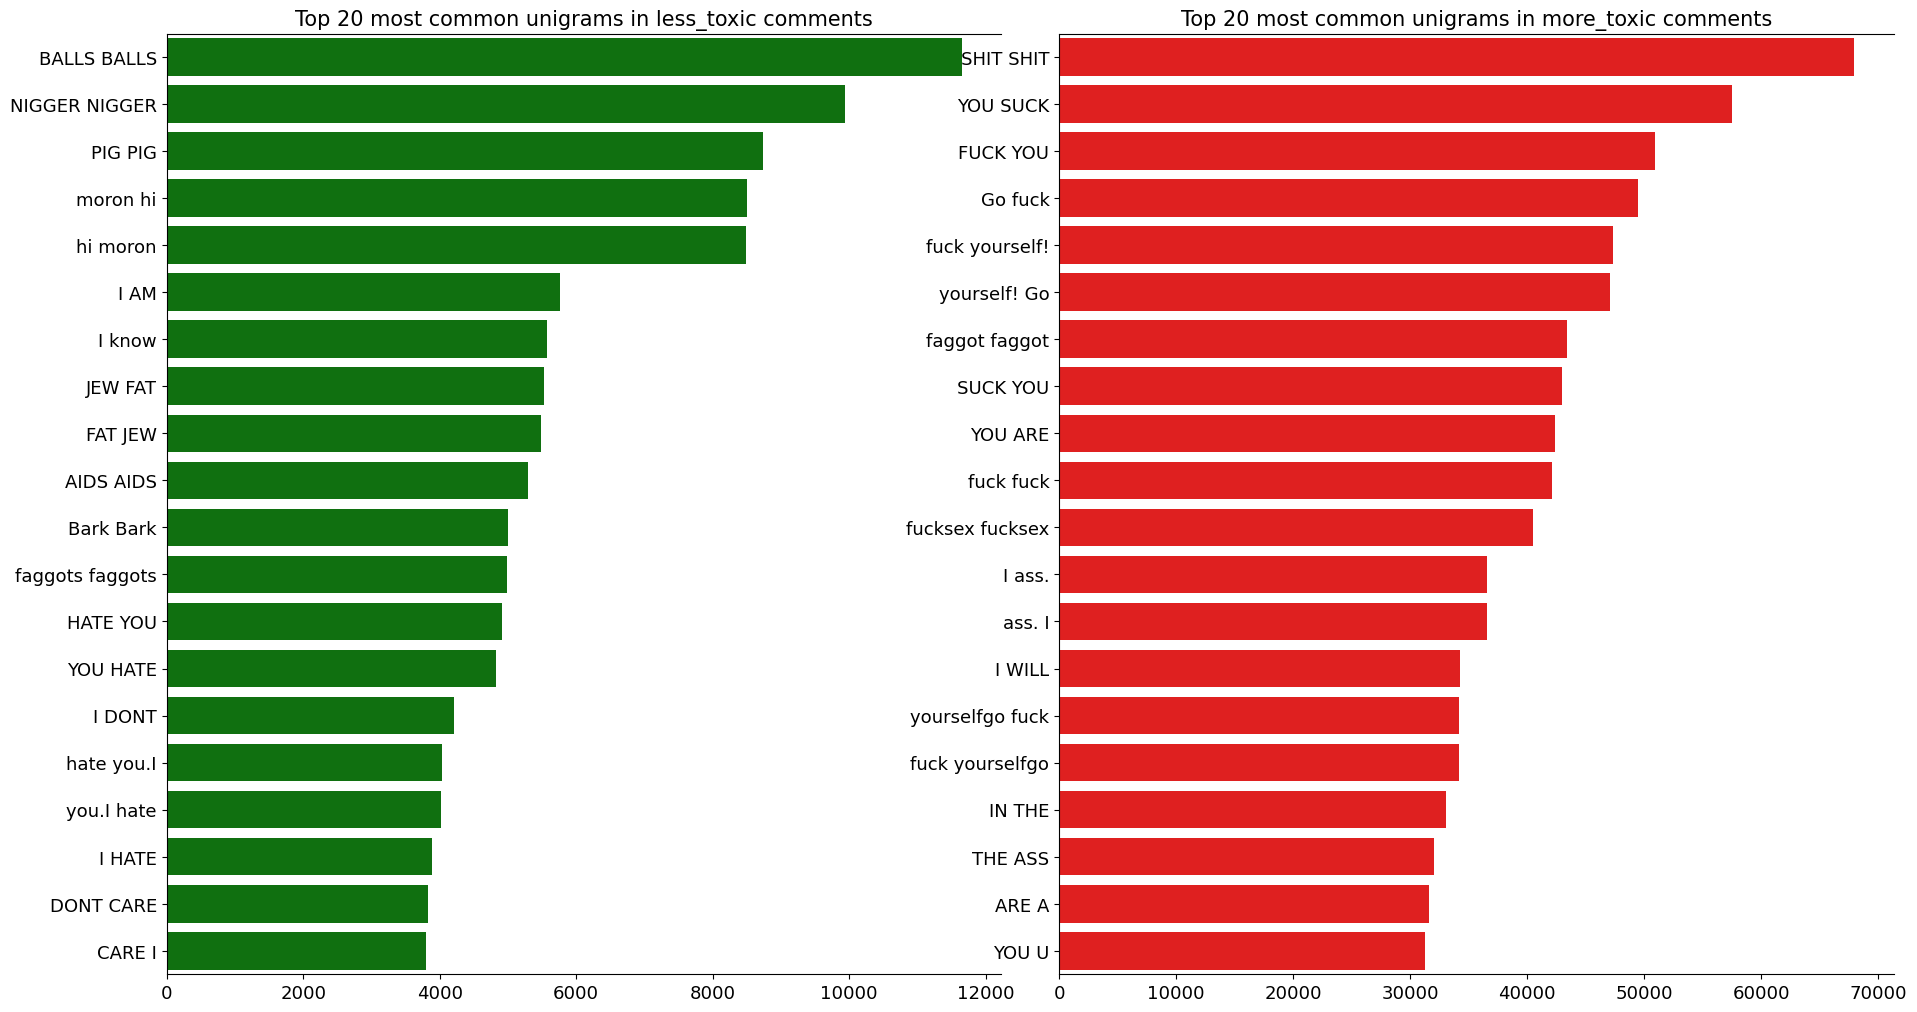

In [22]:
less_toxic_bigrams = defaultdict(int)
for tweet in df['less_toxic']:
    for word in generate_ngrams(tweet, 2):
        less_toxic_bigrams[word] += 1
        
df_less_toxic_bigrams = pd.DataFrame(sorted(less_toxic_bigrams.items(), key=lambda x: x[1])[::-1])

bigrams_less_100 = df_less_toxic_bigrams[:N]

more_toxic_bigrams = defaultdict(int)
for tweet in df['more_toxic']:
    for word in generate_ngrams(tweet, 2):
        more_toxic_bigrams[word] += 1
        
df_more_toxic_bigrams = pd.DataFrame(sorted(more_toxic_bigrams.items(), key=lambda x: x[1])[::-1])

bigrams_more_100 = df_more_toxic_bigrams[:N]

plot(bigrams_less_100, bigrams_more_100)

## BERT Model

In [6]:
## Reading the training data
df = pd.read_csv("train.csv")

df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
105723,35ae5e2f510fef16,September 2008 \n Please stop adding unreferen...,0,0,0,0,0,0
92786,f8194852e0f3fc6a,"Excuse me, I don't like being ignored...could ...",0,0,0,0,0,0
119230,7d685be4742166b7,"""\n\n Re: Help \n\nSorry about the delay, just...",0,0,0,0,0,0
159138,f92b3ee46591939a,Well done! \n\nNow we all know about Buchanan-...,0,0,0,0,0,0
135922,d7028e730a8a364d,"""\n\n Your edit on the Chanticleer Article \n\...",0,0,0,0,0,0


In [7]:
## Creating the variable y which is 1 if sum of other columns is greater than 0 else 0 
df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)

In [8]:
df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,y
49969,8597d708d0341fa8,"Ohhhh! I know what your talking about now, tha...",0,0,0,0,0,0,0
96136,024c3b6a721969f4,Vandalism\n\nYour edits at List of cruelty to ...,0,0,0,0,0,0,0
111514,548f536fa85e6963,Edit request on 7 April 2012 \n\nThere is a pa...,0,0,0,0,0,0,0
124801,9ba87a4e223ff93d,HEY GIRL ! YOU GOT NO MANNER !,1,0,0,0,0,0,1
58355,9c332a81eaae21ab,American English will not TOLERATED!!!!!,0,0,0,0,0,0,0


In [9]:
# Checking the distribution of value of y
df['y'].value_counts()

0    143346
1     16225
Name: y, dtype: int64

In [10]:
## Considering only the required columns and leaving out the rest
df_ = df[['comment_text', 'y']]

## Sampling y to avoid overfitting of the model
df_one = df_[df_['y'] == 1]
df_zero = df_[df_['y'] == 0]

## Since y=0 is greater in the column y, we are sampling it to the length of y=1
df_sample = df_zero.sample(n = len(df_one))
df_sample = pd.concat([df_one, df_sample])

In [11]:
# Checking the distribution of value of y
df_sample['y'].value_counts()

1    16225
0    16225
Name: y, dtype: int64

In [14]:
# !pip install transformers[sentencepiece]

     |████████████████████████████████| 3.3 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 46.3 MB/s 
     |████████████████████████████████| 596 kB 34.3 MB/s 
     |████████████████████████████████| 61 kB 427 kB/s 
     |████████████████████████████████| 895 kB 54.8 MB/s 
     |████████████████████████████████| 1.2 MB 53.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [16]:
df_sample.columns

Index(['comment_text', 'y'], dtype='object')

In [17]:
## Reducing the training size as bert is taking too long to train.
df_sample = df_sample.sample(n = 20000)

In [18]:
## Modelling BERT
training_size = 16000

sentences = df_sample["comment_text"].to_list()
labels = df_sample["y"].to_list()

In [19]:
training_sentences = sentences[0:training_size]
validation_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
validation_labels = labels[training_size:]

In [20]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [18]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['dropout_39', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use it fo

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
model.fit(train_dataset.shuffle(100).batch(16),
          epochs=3,
          batch_size=16,
          validation_data=val_dataset.shuffle(100).batch(16))

Epoch 1/3
1000/1000 [==============================] - 2335s 2s/step - loss: 0.2139 - accuracy: 0.9166 - val_loss: 0.2019 - val_accuracy: 0.9170
Epoch 2/3
1000/1000 [==============================] - 2343s 2s/step - loss: 0.1094 - accuracy: 0.9606 - val_loss: 0.2276 - val_accuracy: 0.9128
Epoch 3/3
1000/1000 [==============================] - 2342s 2s/step - loss: 0.0631 - accuracy: 0.9777 - val_loss: 0.3167 - val_accuracy: 0.9202


In [43]:
## Saving the model for future use
model.save_pretrained("toxic_comment_classifier_bert_trained")

In [23]:
## Loading the trained model for classification
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("toxic_comment_classifier_bert_trained")

Some layers from the model checkpoint at toxic_comment_classifier_bert_trained were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at toxic_comment_classifier_bert_trained and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
## Reading test dataset
df_test = pd.read_csv("test.csv")
df_test_labels = pd.read_csv("test_labels.csv")

## We have test and test labels. So merging them together.
df_test = pd.merge(df_test, df_test_labels, how = 'left', on = 'id')
df_test.head()

## Creating the variable y which is 1 if sum of other columns is greater than 0 else 0 
df_test['y'] = (df_test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)

In [33]:
df_test_one = df_test[df_test['y'] == 1]
df_test_zero = df_test[df_test['y'] == 0]

## Since y=0 is greater in the column y, we are sampling it to the length of y=1
df_test_sample = df_test_zero.sample(n = len(df_test_one))
df_test = pd.concat([df_test_one, df_test_sample])

In [34]:
len(df_test)

12486

In [35]:
df_test = df_test.sample(4000)

In [144]:
test_sentences = df_test["comment_text"].to_list()
test_labels = df_test["y"].to_list()

In [145]:
len(test_sentences)

4000

In [146]:
output = []
for text in test_sentences:
  predict_input = tokenizer.encode(text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")
  # print(predict_input)
  tf_output = loaded_model.predict(predict_input)[0]
  # print(tf_output)
  tf_prediction = tf.nn.softmax(tf_output, axis=1).numpy()
  output.append(tf.argmax(tf_prediction, axis = 1)[0])

In [147]:
print("Classification Report for BERT Model")
print(classification_report(test_labels, output))

Classification Report for BERT Model
              precision    recall  f1-score   support

           0       0.93      0.71      0.81      2041
           1       0.76      0.94      0.84      1959

    accuracy                           0.83      4000
   macro avg       0.84      0.83      0.82      4000
weighted avg       0.85      0.83      0.82      4000



## Naive Bayes and SVM

In [149]:
df_sample.head()

,comment_text,y
132351,"""\n\n Thanks \n\nThanks for all the work you d...",0
60724,"""If you are alleging, per your comments on the...",0
79423,"""\n\nyeah i def agree, Knol will not compete d...",0
140449,I would be very interested in reading more abo...,0
12674,"""\n\n Re: Ridiculous bands listed as supergrou...",0


In [150]:
## Converting to number TF-idf
vectorizer = TfidfVectorizer()
vectorizer.fit(df['comment_text'])

TfidfVectorizer()

In [151]:
def tfidf_vectorizer(df, train = 1):
    ## Creating features and labels
    X = vectorizer.transform(df['comment_text'])
    if train:
        y = df['y']
        return X, y
    return X

## Fitting the model
def modelling(model, X_train, X_test, y_train):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return model, pred

In [152]:
## Vectorizing the trainig and testing data to feed it as input to model training and prediction. 
X_train, y_train = tfidf_vectorizer(df_sample)
X_test = tfidf_vectorizer(df_test, train = 0)
y_test = df_test['y']

## Defining SVM Model
SVM = svm.SVC(kernel = 'linear', gamma = 'auto', probability = True)

## Defining Naive Bayes Model
NB = MultinomialNB()

In [153]:
## Training and Prediction for SVM Model
SVM_model, SVM_prediciton = modelling(SVM, X_train, X_test, y_train)

In [154]:
## Training and Prediction for Naive Bayes Model
NB_model, NB_prediciton = modelling(NB, X_train, X_test, y_train)

In [155]:
print("Classification Report for SVM Model")
print(classification_report(y_test, SVM_prediciton))

print("Classification Report for Naive Bayes Model")
print(classification_report(y_test, NB_prediciton))

Classification Report for SVM Model
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      2041
           1       0.77      0.92      0.84      1959

    accuracy                           0.83      4000
   macro avg       0.84      0.83      0.83      4000
weighted avg       0.84      0.83      0.83      4000

Classification Report for Naive Bayes Model
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      2041
           1       0.77      0.87      0.82      1959

    accuracy                           0.81      4000
   macro avg       0.82      0.81      0.81      4000
weighted avg       0.82      0.81      0.81      4000



## RNN

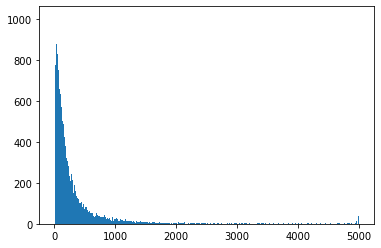

In [156]:
## Plotting the histogram to check the distribution of length of each reviews. 
plt.hist([len(x) for x in df_sample['comment_text']], bins=500)
plt.show()

In [157]:
## Hyper-parameters considered for building the model
embedding_dim = 300
max_length = 1000
padding_type = 'post'
trunc_type = 'post'
oov_tok = "<oov>"

In [161]:
## Tokenizing the sentenes
tokenizer = Tokenizer(oov_token = oov_tok)
tokenizer.fit_on_texts(df_sample['comment_text'])
word_index = tokenizer.word_index

In [162]:
##training sequences and labels
train_seqs = tokenizer.texts_to_sequences(df_sample['comment_text'])
train_padded = pad_sequences(train_seqs,maxlen=max_length, truncating=trunc_type)

In [168]:
## Model Architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [169]:
## Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 300)         15694500  
                                                                 
 bidirectional_2 (Bidirectio  (None, 1000, 512)        1140736   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,524,645
Trainable params: 17,524,645


In [170]:
## Compiling the model. The loss function considered is binary crossentropy as we are predicting on only two classes. 
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [171]:
## Input to tesnorflow model should always be np array format
train_labels = np.array(df_sample["y"])

In [172]:
## Make sure to use GPU before running this cell. Time takes per epoch without gpu is 19 min
num_epochs = 10
## For early stopping to ensure it doesnt overfit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model.fit(
    train_padded, 
    train_labels, 
    epochs=num_epochs,
    batch_size = 256,
    callbacks=[callback]
    )

Epoch 1/10
79/79 [==============================] - 255s 3s/step - loss: 0.4224 - accuracy: 0.7940
Epoch 2/10
79/79 [==============================] - 245s 3s/step - loss: 0.2090 - accuracy: 0.9204
Epoch 3/10
79/79 [==============================] - 245s 3s/step - loss: 0.1338 - accuracy: 0.9524
Epoch 4/10
79/79 [==============================] - 245s 3s/step - loss: 0.2687 - accuracy: 0.8938
Epoch 5/10
79/79 [==============================] - 245s 3s/step - loss: 0.1686 - accuracy: 0.9385


In [173]:
## Predicting the output
X_ = tokenizer.texts_to_sequences(df_test['comment_text'])
test_padded = pad_sequences(X_, maxlen=max_length, truncating=trunc_type)

In [174]:
pred = model.predict(test_padded)

In [179]:
output = []

for i in pred:
  if i > 0.5:
    output.append(1)
  else:
    output.append(0)

In [180]:
print("Classification Report for RNN Model")
print(classification_report(y_test, output))

Classification Report for RNN Model
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      2041
           1       0.77      0.89      0.83      1959

    accuracy                           0.82      4000
   macro avg       0.83      0.82      0.82      4000
weighted avg       0.83      0.82      0.82      4000



## Ridge Regression

In [25]:
## Since this challenge is about rating the severity of the toxicity, we will give more weightage to sever_toxic column
df['severe_toxic'] = df['severe_toxic']*2.5

## Lets have our y variable as sum of all the toxicity
df['y'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis = 1).astype(int)

In [26]:
## Getting rid of all other columns except out text and y
df = df[['comment_text', 'y']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f376575afd0>]],
      dtype=object)

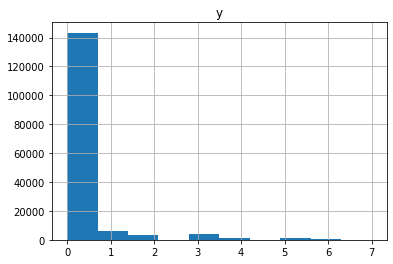

In [27]:
## Lets have a look at the distribution of y variable
df.hist(column = "y")

In [28]:
## Sampling the data
df = pd.concat([df[df['y'] > 0], df[df['y'] == 0].sample(int(len(df[df['y'] > 0])*1.5))], axis = 0).sample(frac = 1)

#### Building a Regression model using Ridge Regression

In [29]:
vectorizer = TfidfVectorizer(analyzer = 'char_wb', max_df = 0.5, min_df = 3, ngram_range = (3,6))
X = vectorizer.fit_transform(df['comment_text'])

## Looking at the shape of the created data
X.shape

(40562, 280794)

In [30]:
## Modelling
model = Ridge()
model.fit(X, df['y'])

Ridge()

In [37]:
## Extracting the text and converting it for the model 
X_ = vectorizer.transform(df_test['comment_text'])
pred = model.predict(X_)

In [40]:
pred

array([-0.11066748,  1.20056926,  1.74841671, ...,  2.58080592,
        0.96350508,  1.48464132])

In [41]:
df_test["score"] = pred